<a href="https://colab.research.google.com/github/poojithareddy39/Firstgithub/blob/main/Sales_Forecasting_For_Retail_Business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:

def generate_sample_retail_data():

    date_range = pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')
    n = len(date_range)
    base_sales = 1000 + 300 * np.sin(np.arange(n) * (2 * np.pi / 7))
    yearly_seasonality = 500 * np.sin(np.arange(n) * (2 * np.pi / 365))
    holiday_effect = np.zeros(n)
    new_year_idx = pd.DatetimeIndex(['2021-01-01', '2022-01-01']).dayofyear - 1
    for idx in new_year_idx:
        if idx < n:
            holiday_effect[idx] = 500
            holiday_effect[idx+1] = 200
    black_friday_idx = pd.DatetimeIndex(['2021-11-26', '2022-11-25']).dayofyear - 1
    for idx in black_friday_idx:
        if idx < n:
            holiday_effect[idx] = 1000
            holiday_effect[idx+1] = 800
            holiday_effect[idx+2] = 600
    christmas_start_idx = pd.DatetimeIndex(['2021-12-15', '2022-12-15']).dayofyear - 1
    for idx in christmas_start_idx:
        if idx < n:
            for j in range(10):
                if idx+j < n:
                    holiday_effect[idx+j] = 300 + j*50
    trend = np.linspace(0, 800, n)
    noise = np.random.normal(0, 50, n)
    sales = base_sales + yearly_seasonality + trend + holiday_effect + noise
    df = pd.DataFrame({
        'Date': date_range,
        'Sales': sales.astype(int)
    })

    return df
sales_data = generate_sample_retail_data()
print("Sample Retail Sales Data:")
sales_data.head()

Sample Retail Sales Data:


,Date,Sales
0,2021-01-01,1454
1,2021-01-02,1465
2,2021-01-03,1375
3,2021-01-04,1099
4,2021-01-05,965


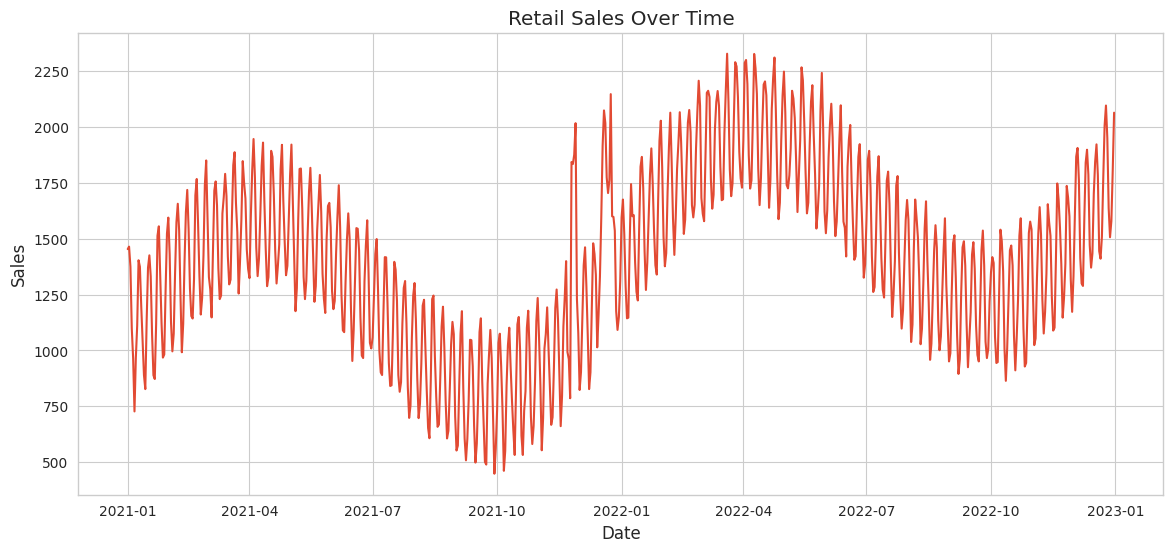

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(sales_data['Date'], sales_data['Sales'])
plt.title('Retail Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()
fig = px.line(sales_data, x='Date', y='Sales', title='Retail Sales Trend')
fig.update_layout(xaxis_title='Date', yaxis_title='Sales')
fig.show()

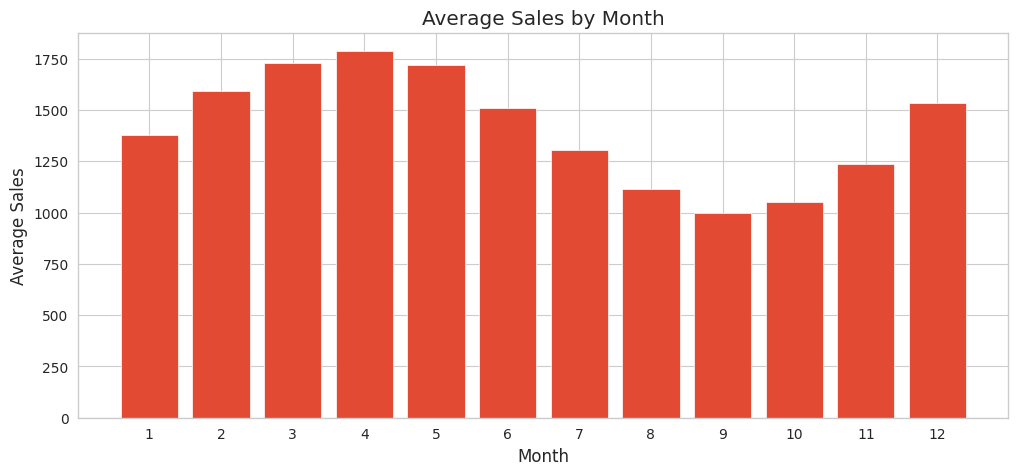

In [4]:

sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month
sales_data['DayOfWeek'] = sales_data['Date'].dt.dayofweek
sales_data['DayOfMonth'] = sales_data['Date'].dt.day
sales_data['Quarter'] = sales_data['Date'].dt.quarter
monthly_sales = sales_data.groupby('Month')['Sales'].mean().reset_index()
plt.figure(figsize=(12, 5))
plt.bar(monthly_sales['Month'], monthly_sales['Sales'])
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.grid(True, axis='y')
plt.show()
fig_monthly = px.bar(monthly_sales, x='Month', y='Sales',
                    title='Average Sales by Month',
                    labels={'Month': 'Month', 'Sales': 'Average Sales'})
fig_monthly.show()

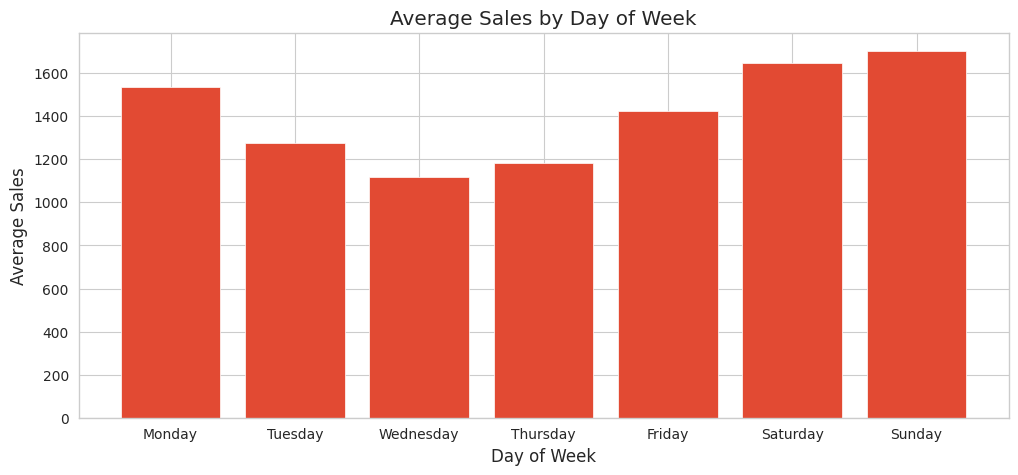

In [5]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_data['DayName'] = sales_data['DayOfWeek'].apply(lambda x: days[x])
weekly_sales = sales_data.groupby('DayOfWeek')['Sales'].mean().reset_index()
weekly_sales['DayName'] = weekly_sales['DayOfWeek'].apply(lambda x: days[x])
plt.figure(figsize=(12, 5))
plt.bar(weekly_sales['DayName'], weekly_sales['Sales'])
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.grid(True, axis='y')
plt.show()
fig_weekly = px.bar(weekly_sales, x='DayName', y='Sales',
                   title='Average Sales by Day of Week',
                   labels={'DayName': 'Day of Week', 'Sales': 'Average Sales'})
fig_weekly.show()

In [6]:
prophet_df = sales_data[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
from prophet.make_holidays import make_holidays_df
model.add_country_holidays(country_name='US')
model.fit(prophet_df)
future_periods = 90
future = model.make_future_dataframe(periods=future_periods)
forecast = model.predict(future)
print("Forecast Components:")
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxq4m_gz5/2f89edw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxq4m_gz5/y4g025px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99352', 'data', 'file=/tmp/tmpxq4m_gz5/2f89edw2.json', 'init=/tmp/tmpxq4m_gz5/y4g025px.json', 'output', 'file=/tmp/tmpxq4m_gz5/prophet_modelrcjpkpkr/prophet_model-20250506083800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast Components:


,ds,yhat,yhat_lower,yhat_upper
815,2023-03-27,2322.303453,2211.114409,2431.730902
816,2023-03-28,2067.012786,1960.444415,2164.331628
817,2023-03-29,1913.633201,1806.814617,2021.756590
818,2023-03-30,1967.624565,1863.306507,2079.131514
819,2023-03-31,2219.631144,2113.856544,2323.852719


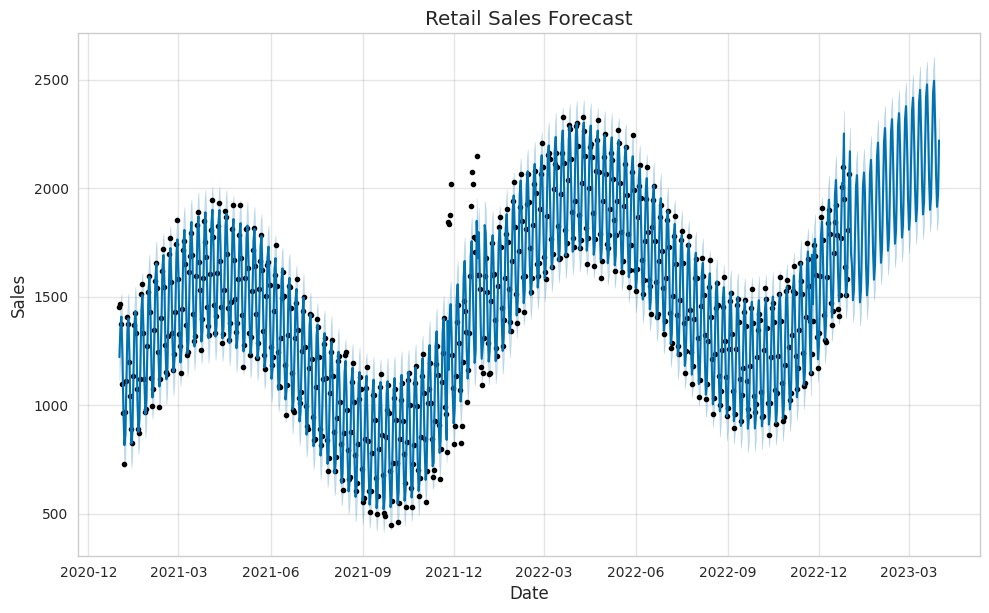

In [7]:
fig1 = model.plot(forecast)
plt.title('Retail Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()
fig_forecast = plot_plotly(model, forecast)
fig_forecast.update_layout(
    title='Retail Sales Forecast',
    xaxis_title='Date',
    yaxis_title='Sales'
)
fig_forecast.show()

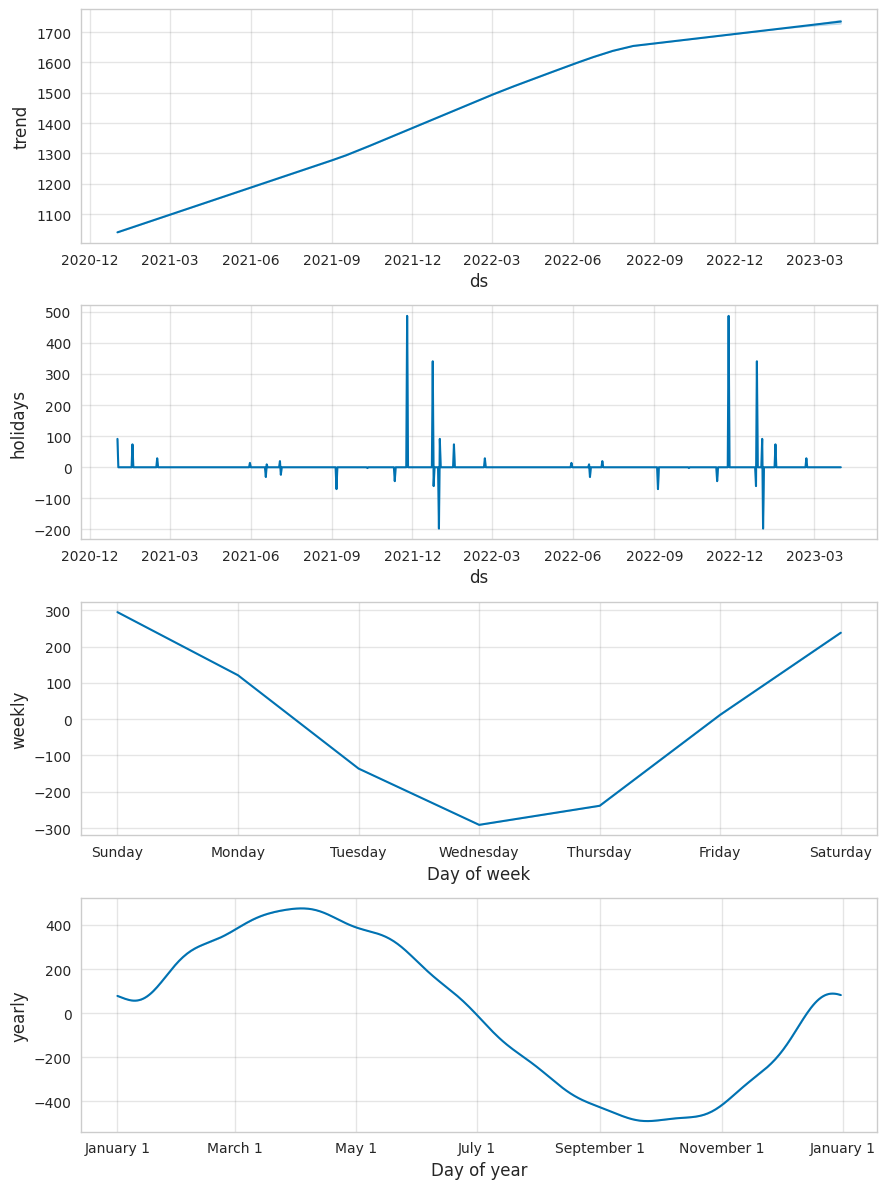

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [8]:
fig2 = model.plot_components(forecast)
plt.show()
fig_components = plot_components_plotly(model, forecast)
fig_components.show()

In [9]:
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }
actual = prophet_df['y'].values
predicted = forecast['yhat'][:len(actual)].values
metrics = evaluate_forecast(actual, predicted)
print("Prophet Model Performance Metrics:")
for metric, value in metrics.items():
    if metric == 'MAPE':
        print(f"{metric}: {value:.2f}%")
    else:
        print(f"{metric}: {value:.2f}")

Prophet Model Performance Metrics:
MAE: 50.09
RMSE: 82.61
R²: 0.96
MAPE: 3.82%


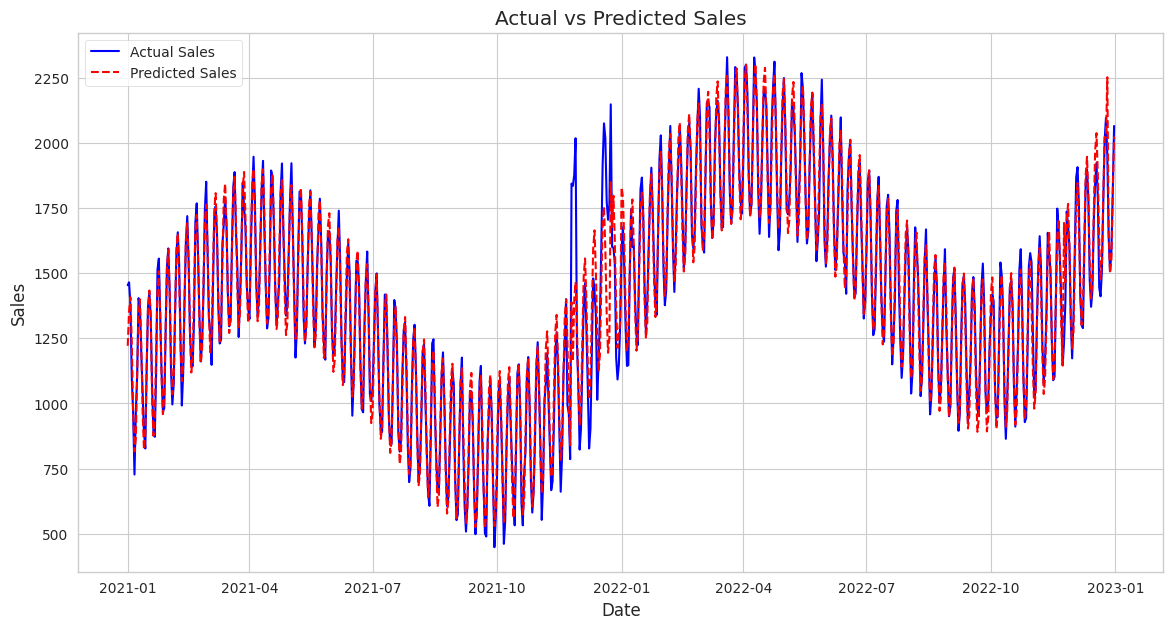

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual Sales', color='blue')
plt.plot(forecast['ds'][:len(actual)], forecast['yhat'][:len(actual)],
         label='Predicted Sales', color='red', linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
fig = go.Figure()
fig.add_trace(go.Scatter(x=prophet_df['ds'], y=prophet_df['y'],
                         mode='lines', name='Actual Sales'))
fig.add_trace(go.Scatter(x=forecast['ds'][:len(actual)], y=forecast['yhat'][:len(actual)],
                         mode='lines', name='Predicted Sales', line=dict(dash='dash')))
fig.update_layout(title='Actual vs Predicted Sales',
                 xaxis_title='Date',
                 yaxis_title='Sales')
fig.show()

In [11]:
def create_features(df):
    df = df.copy()
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month
    df['day_of_month'] = df['ds'].dt.day
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['day_of_year'] = df['ds'].dt.dayofyear
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    df['quarter'] = df['ds'].dt.quarter
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    for lag in [1, 7, 14, 30]:
        if len(df) > lag:
            df[f'sales_lag_{lag}'] = df['y'].shift(lag)
    for window in [7, 14, 30]:
        if len(df) > window:
            df[f'sales_rolling_mean_{window}'] = df['y'].rolling(window=window).mean()
            df[f'sales_rolling_std_{window}'] = df['y'].rolling(window=window).std()
    df = df.dropna()
    return df
featured_df = create_features(prophet_df.copy())
print("Features created:")
featured_df.head()

Features created:


,ds,y,year,month,day_of_month,day_of_week,day_of_year,week_of_year,quarter,is_weekend,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_30,sales_rolling_mean_7,sales_rolling_std_7,sales_rolling_mean_14,sales_rolling_std_14,sales_rolling_mean_30,sales_rolling_std_30
30,2021-01-31,1595,2021,1,31,6,31,4,1,1,1523.0,1556.0,1426.0,1454.0,1256.285714,247.728826,1224.857143,255.967203,1184.166667,243.658761
31,2021-02-01,1431,2021,2,1,0,32,5,1,0,1595.0,1332.0,1332.0,1465.0,1270.428571,255.476585,1231.928571,260.482530,1183.033333,242.383208
32,2021-02-02,1125,2021,2,2,1,33,5,1,0,1431.0,1122.0,1072.0,1375.0,1270.857143,255.188446,1235.714286,258.355875,1174.700000,239.839911
33,2021-02-03,996,2021,2,3,2,34,5,1,0,1125.0,968.0,889.0,1099.0,1274.857143,249.812882,1243.357143,248.712873,1171.266667,241.691016
34,2021-02-04,1075,2021,2,4,3,35,5,1,0,996.0,982.0,872.0,965.0,1288.142857,233.588262,1257.857143,230.659542,1174.933333,239.276198


In [12]:
test_size = 0.2
X = featured_df.drop(['ds', 'y'], axis=1)
y = featured_df['y']
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (560, 18)
Test set: (140, 18)


In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = evaluate_forecast(y_test, y_pred)
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'metrics': metrics
    }
    print(f"{name} Performance:")
    for metric, value in metrics.items():
        if metric == 'MAPE':
            print(f"  {metric}: {value:.2f}%")
        else:
            print(f"  {metric}: {value:.2f}")
    print()

Linear Regression Performance:
  MAE: 47.72
  RMSE: 59.96
  R²: 0.96
  MAPE: 3.62%

Random Forest Performance:
  MAE: 72.50
  RMSE: 94.41
  R²: 0.89
  MAPE: 5.12%



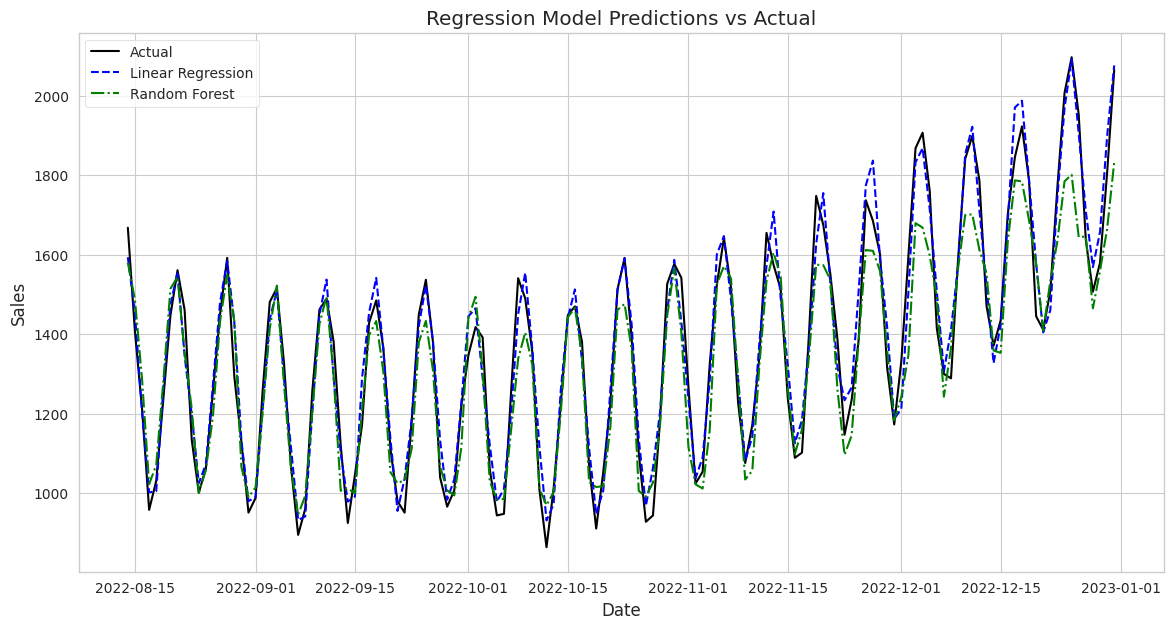

In [14]:
test_dates = featured_df['ds'].iloc[split_idx:].reset_index(drop=True)
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test.reset_index(drop=True), label='Actual', color='black')
for name, result in results.items():
    if name == 'Linear Regression':
        style = 'b--'
    elif name == 'Random Forest':
        style = 'g-.'
    plt.plot(test_dates, result['predictions'], style, label=name)
plt.title('Regression Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
fig = go.Figure()
fig